## Linear models for predicting MLB salary in 6 years with rookie stats

### Future notes / todos
* Probably need to get more data

In [56]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from  matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [19]:
# set paths of the data files
PATH_S = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/hist_salaries.csv'
PATH_R = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/rookies.csv'
PATH_RS = '/Users/jadams/ds/metis/baseball_lin_regression/data/processed_df/agg_df_stats.csv'

In [20]:
def mean_mse_Lasso(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [21]:
def mean_mse_Ridge(model,name):
    mse = model.get_params()[name].mse_path_
    alphas = model.get_params()[name].alphas_
    mse_df = pd.DataFrame(data=mse, index=alphas)
    return mse_df.loc[model.get_params()[name].alpha_].mean()

In [22]:
# get the salary and stats data
df_stats = pd.read_csv(PATH_RS, index_col = 0)
df_salary = pd.read_csv(PATH_S, index_col = 0)

Merge the stats and salary data frames together. `df_stats` has only rookie batters from 1985-2017. `df_salary` has all MLB salaries from 1985-2017 as long as the player was paid for 6 years from rookie season.

In [23]:
salary_stats_df = df_stats.merge(df_salary, on='name_year')
salary_stats_df = salary_stats_df.loc[:,['Year_x', 'Age_x', 'name_x', 'debut', 'position', 'G', 'PA', 'AB', 'R',
       'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'BA', 'name_year', 'award_count',
        'Salary', 'SrvTm', 'today_salary']]
salary_stats_df.rename(columns={'Year_x':'rookie_year', 'Age_x':'age', 'name_x':'name'}, inplace=True)
salary_stats_df['log_today_salary'] = np.log10(salary_stats_df.today_salary) # log transform the salary
salary_stats_df.shape

(919, 25)

Create `X` and `y`, and make a train / test split of 20%.

In [24]:
y = salary_stats_df.log_today_salary

X = salary_stats_df.loc[:,['G', 'PA', 'AB', 'R', 'H', 'SB', 'HR', 'TB', '2B', '3B', 'RBI', 'BB', 'SO', 'BA', 'age', 'award_count']]
print('X sample:',X.shape)
print('y sample:',y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print('X train:', X_train.shape)
print('y train:', y_train.shape)

X sample: (919, 16)
y sample: (919,)
X train: (735, 16)
y train: (735,)


Combine `X` and `y` training data sets and calculate the correlation matrix.

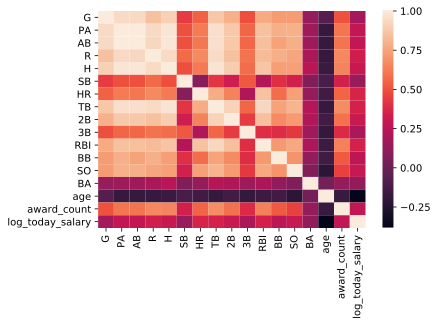

In [25]:
Xy = pd.concat([X_train, y_train], axis=1)
# sns.pairplot(Xy);

corr = Xy.corr()
sns.heatmap(corr);

HRs and age of rookie year are somewhat correlated with salary in 6 years. Whereas, games (G) and stolen bases (SB) are less related to salary in 6 years.

Build a basic linear regression model with all features as a baseline to compare against the Lasso models

In [26]:
model_results = pd.Series(name='MSE')

Add a 10-fold cross-validation linear regression model.

In [27]:
lin_model = LinearRegression()
scores = cross_val_score(lin_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
model_results['linear model - cv10'] = np.mean(-scores)
model_results

linear model - cv10    0.163293
Name: MSE, dtype: float64

Build a Lasso model with standard scaling.

Now perform a 10-fold cross validation for same range of alphas.

In [28]:
alphas = [10**a for a in range(-2,5)]

In [29]:
cv_lasso = make_pipeline(StandardScaler(), LassoCV(cv=10, alphas=alphas, tol=0.001))
cv_lasso.fit(X_train, y_train)
model_results['lasso cv - ' + str(cv_lasso.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso, 'lassocv')
model_results.sort_values()

lasso cv - 0.01        0.162235
linear model - cv10    0.163293
Name: MSE, dtype: float64

Now 2-5 degree polynomial features and perform a 10-fold cross validation.

In [30]:
for degrees in range(2,6):
    cv_lasso_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), LassoCV(cv=10, alphas=alphas,tol=0.001))
    cv_lasso_poly.fit(X_train, y_train)
    model_results['lasso poly ' + str(degrees) + ' cv - ' + str(cv_lasso_poly.get_params()['lassocv'].alpha_)] = mean_mse_Lasso(cv_lasso_poly, 'lassocv')

In [31]:
model_results.sort_values()

lasso cv - 0.01           0.162235
lasso poly 2 cv - 0.01    0.162354
lasso poly 3 cv - 0.01    0.162623
lasso poly 4 cv - 0.01    0.162838
linear model - cv10       0.163293
lasso poly 5 cv - 0.01    0.163766
Name: MSE, dtype: float64

In [67]:
pipeline = Pipeline([('poly', PolynomialFeatures()), ('scal', StandardScaler()), ('lasso', Lasso(tol=0.001))])
pipeline

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scal', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.001, warm_start=False))])

In [81]:
# lasso = make_pipeline(StandardScaler(), Lasso(tol=0.001))
alphas = np.logspace(-4, -0.5, 30)
degrees = range(1,6)
tuned_parameters = [{'lasso__alpha': alphas, 'poly__degree': degrees}]
n_folds = 5

lasso_gcv = GridSearchCV(pipeline, tuned_parameters, cv=n_folds, return_train_score=True, scoring='neg_mean_squared_error')

In [82]:
lasso_gcv.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scal', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'lasso__alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01]), 'poly__degree': range(1, 6)}],
       pr

In [83]:
lasso_gcv.best_estimator_

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('scal', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.008531678524172814, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.001, warm_start=False))])

In [87]:
gcv_results = pd.DataFrame(lasso_gcv.cv_results_)

In [89]:
gcv_results[gcv_results.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
80,0.002683,0.000067,0.000669,0.000015,0.00853168,1,"{'lasso__alpha': 0.008531678524172814, 'poly__...",-0.148225,-0.145436,-0.165544,...,-0.164194,0.021957,1,-0.158775,-0.160334,-0.154794,-0.145141,-0.156753,-0.15516,0.005346


In [90]:
gcv_results.to_csv('data/gcv_results.csv')

In [84]:
scores = -lasso_gcv.cv_results_['mean_test_score']
scores_std = lasso_gcv.cv_results_['std_test_score']
scores.shape
# np.min(scores)

(150,)

ValueError: x and y must have same first dimension, but have shapes (30,) and (150,)

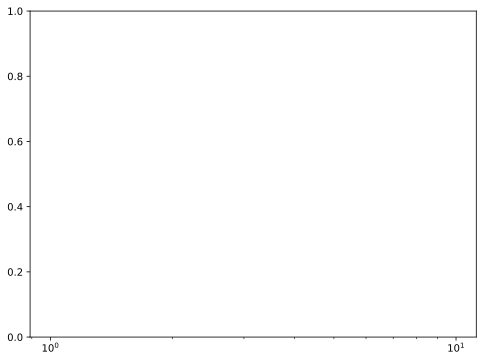

In [85]:

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.min(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]]);

In [15]:
## Talk to Spencer tomorrow possibly
# ## Broken need to use the cv_values_
# for degrees in range(2,3):
#     cv_ridge_poly = make_pipeline(PolynomialFeatures(degrees), StandardScaler(), RidgeCV(cv=10, alphas=alphas))
#     cv_ridge_poly.fit(X_train, y_train)
# #     model_results['ridge poly ' + str(degrees) + ' cv - ' + str(cv_ridge_poly.get_params()['ridgecv'].alpha_)] = mean_mse(cv_ridge_poly, 'ridgecv')

In [16]:
# cv_ridge_poly.get_params()['ridgecv'].alpha_

In [17]:
# model_results.sort_values()